In [ ]:
# === MOUNT DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import shutil             # to copy images to another directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

In [ ]:
# --------------------------
# 1. Dataset paths
# --------------------------
base_dir = '/content/drive/MyDrive/splitted_dataset_811'

train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

selectedClasses = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

In [ ]:
# --------------------------
# 2. ImageDataGenerators
# --------------------------
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=(1.0,1.2),
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    classes=selectedClasses
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    classes=selectedClasses
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='categorical',
    classes=selectedClasses,
    shuffle=False
)

Found 6222 images belonging to 5 classes.
Found 777 images belonging to 5 classes.
Found 778 images belonging to 5 classes.


In [ ]:
# --------------------------
# 3. Model
# --------------------------
with tf.device('/GPU:0'):
    Model = Sequential([
        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.08),
        Dense(len(selectedClasses), activation='softmax')
    ])

# Freeze layers except last 4
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:
    layer.trainable = False

Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,014,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,127,505 (57.71 MB)

 Trainable params: 4,427,397 (16.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

 Optimizer params: 8,854,796 (33.78 MB)

In [ ]:
# --------------------------
# 4. Training
# --------------------------
history = Model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=4,
        monitor='val_accuracy',
        restore_best_weights=True
    )]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3029s 15s/step - accuracy: 0.6924 - loss: 0.8709 - val_accuracy: 0.7954 - val_loss: 0.6283
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 634ms/step - accuracy: 0.8265 - loss: 0.4592 - val_accuracy: 0.8571 - val_loss: 0.4183
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 118s 601ms/step - accuracy: 0.8813 - loss: 0.3268 - val_accuracy: 0.8713 - val_loss: 0.3554
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 118s 607ms/step - accuracy: 0.8948 - loss: 0.2991 - val_accuracy: 0.8764 - val_loss: 0.3448
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 118s 605ms/step - accuracy: 0.9022 - loss: 0.2759 - val_accuracy: 0.8764 - val_loss: 0.3258
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 116s 595ms/step - accuracy: 0.9125 - loss: 0.2368 - val_accuracy: 0.8996 - val_loss: 0.3320
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 117s 599ms/step - accuracy: 0.9250 - loss: 0.2071 - val_accuracy: 0.8958 - val_loss: 0.3250
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 115s 590ms/step - accuracy: 0.9248 - 

In [ ]:
# --------------------------
# 5. Evaluation
# --------------------------
test_loss, test_accuracy = Model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

predictions = Model.predict(test_generator)
predictedClasses = predictions.argmax(axis=-1)
trueClasses = test_generator.classes


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 434s 4s/step - accuracy: 0.9306 - loss: 0.1919
Test Accuracy: 0.9408740401268005
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step


In [ ]:
Model.save('MobileNetV2_811.h5')
Model.save('MobileNetV2_811.keras')

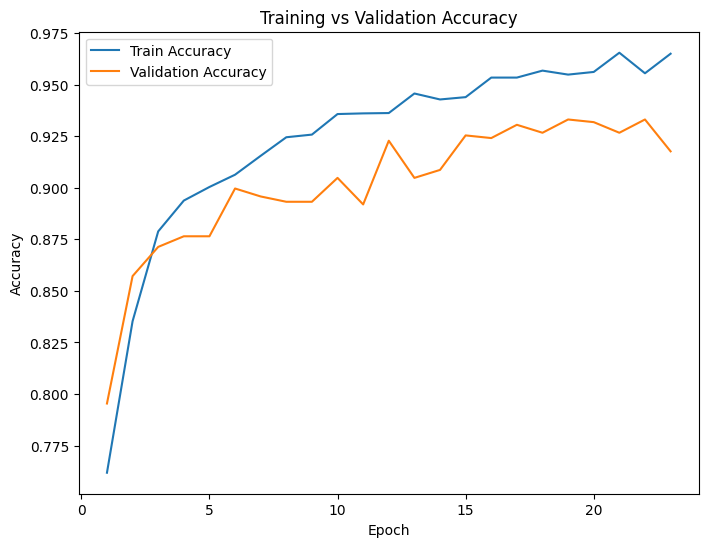

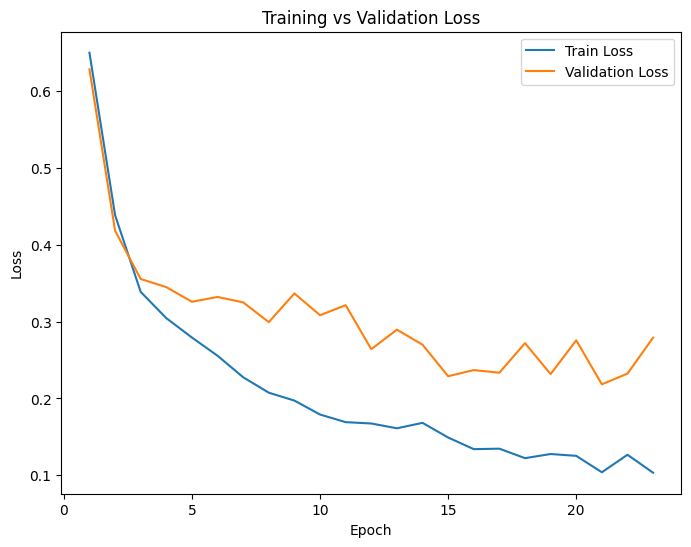

In [ ]:
# --------------------------
# 6. Plotting
# --------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Use white background
sns.set_style("white")
plt.style.use('default')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize=(8,6))
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(False)
plt.show()

# Loss plot
plt.figure(figsize=(8,6))
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(generator, model, title="Confusion Matrix"):
    # Ensure generator is not shuffled
    generator.shuffle = False

    # Predict
    Y_pred = model.predict(generator)
    y_pred_classes = np.argmax(Y_pred, axis=1)
    y_true = generator.classes  # aligned because shuffle=False

    # Class labels
    class_labels = list(generator.class_indices.keys())

    # Normalized confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes, normalize='true')

    # Plot
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.xticks(np.arange(len(class_labels))+0.5, class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels))+0.5, class_labels, rotation=45)
    plt.show()

# Make sure training generator has shuffle=False for confusion matrix
train_generator.shuffle = False
test_generator.shuffle = False

# Training confusion matrix
plot_confusion_matrix(train_generator, Model, title="Training Confusion Matrix (Normalized)")

# Testing confusion matrix
plot_confusion_matrix(test_generator, Model, title="Testing Confusion Matrix (Normalized)")


NameError: name 'train_generator' is not defined

98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


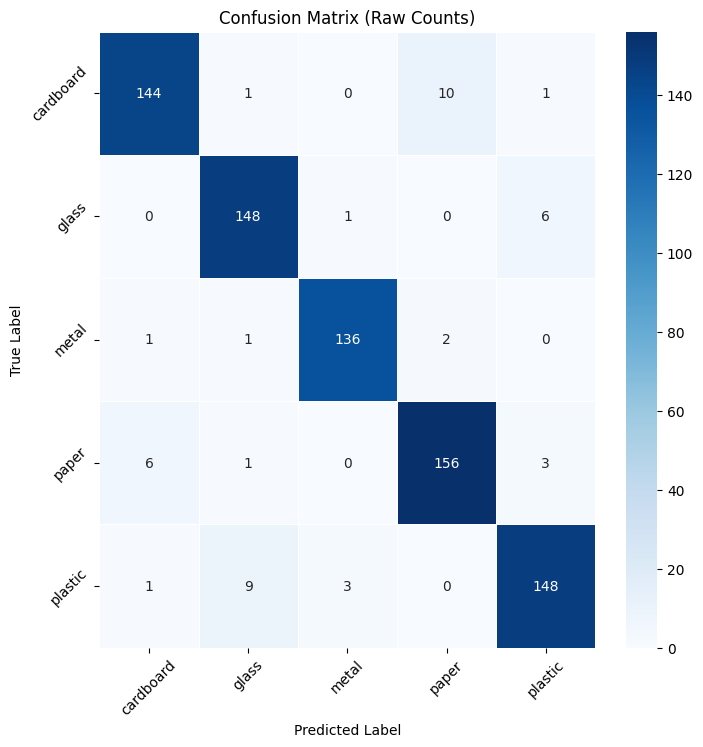

In [ ]:
# --------------------------
# 7. Confusion Matrix
# --------------------------
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure test generator is not shuffled
test_generator.shuffle = False

# Predictions
Y_pred = Model.predict(test_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Raw counts confusion matrix
cm_counts = confusion_matrix(y_true, y_pred_classes)  # raw counts

# Plot
plt.figure(figsize=(8,8))
sns.heatmap(cm_counts, annot=True, fmt='d', cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Raw Counts)")
plt.xticks(np.arange(len(class_labels))+0.5, class_labels, rotation=45)
plt.yticks(np.arange(len(class_labels))+0.5, class_labels, rotation=45)
plt.show()


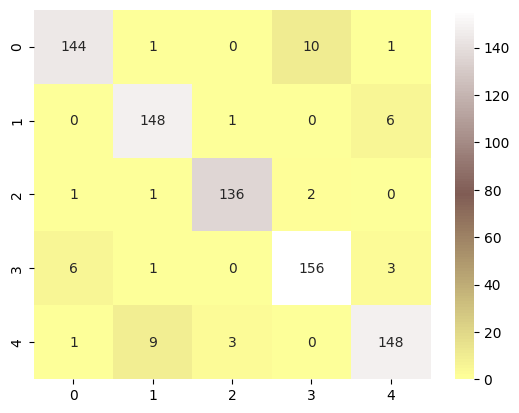

In [ ]:
CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [ ]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       156
           1       0.93      0.95      0.94       155
           2       0.97      0.97      0.97       140
           3       0.93      0.94      0.93       166
           4       0.94      0.92      0.93       161

    accuracy                           0.94       778
   macro avg       0.94      0.94      0.94       778
weighted avg       0.94      0.94      0.94       778



In [ ]:
# --------------------------
# 8. Classification Report
# --------------------------
from sklearn.metrics import classification_report
import numpy as np

# Make sure test generator is not shuffled
test_generator.shuffle = False

# Predict
Y_pred = Model.predict(test_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:\n")
print(report)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
Classification Report:

              precision    recall  f1-score   support

   cardboard       0.95      0.92      0.94       156
       glass       0.93      0.95      0.94       155
       metal       0.97      0.97      0.97       140
       paper       0.93      0.94      0.93       166
     plastic       0.94      0.92      0.93       161

    accuracy                           0.94       778
   macro avg       0.94      0.94      0.94       778
weighted avg       0.94      0.94      0.94       778

